In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.autograd as ag
import matplotlib.pyplot as plt

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import LBFGS

<h1> Solution to Lane Emden Equation </h1>

<p> Ignoring at x = 0 (as it is a singularity) </p>

In [ ]:
def solution(x):
    with np.errstate(divide='ignore', invalid='ignore'):
        y = np.where(x == 0, 1, np.sin(x) / x)
    return y

The derivative function

In [ ]:
def derivative(x):
    yd = np.cos(x)/x - np.sin(x)/x**2
    return yd

<h1>Neural Network Architecture</h1>

<p>Defining the Neural Network Class, which will be called multiple times throughout the program</p>

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size: int = 1, output_size: int = 1, hidden_layers: int = 5, hidden_nodes: int = 10) -> None:
        super().__init__()

        self.inputs  = nn.Linear(input_size, hidden_nodes)
        self.model   = nn.ModuleList([nn.Linear(hidden_nodes, hidden_nodes)] * hidden_layers)
        self.outputs = nn.Linear(hidden_nodes, output_size)

        self.activation = nn.Tanh()

    def _apply_model(self, x: torch.Tensor) -> torch.Tensor:
      for layer in self.model:
          x = self.activation(layer(x))
      return x

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        t = self.activation(self.inputs(t))
        t = self._apply_model(t)
        t = self.outputs(t)
        return t

<h1>Generate Training Data</h1>

<h2> Defining Function to Create training points, with number of collocation points as an argument </h2>

In [ ]:
def create_training_points(no_colloc_points):
    x = np.linspace(0, 5, 500).reshape(-1, 1)  # Training Points
    y = solution(x).reshape(-1, 1)

    x_data = x[0:300:300] # Reducing the training points
    y_data = y[0:300:300]
    y_data[0] = 1

    x_data = torch.tensor(x_data, dtype=torch.float32)
    y_data = torch.tensor(y_data, dtype=torch.float32)

    x_physics = torch.linspace(0, 5, no_colloc_points, requires_grad=True, dtype=torch.float32).reshape(-1, 1) # Collocation Points
    return x_data, y_data, x_physics

<h1>Hyperparameters and Training (Without Physics Loss)</h1>

In [ ]:
EPOCHS = 20000
LR = 3e-3

model = NeuralNetwork(hidden_layers = 1, hidden_nodes = 32)
optim = torch.optim.Adam(model.parameters(),lr=LR)
scheduler = ReduceLROnPlateau(optim, mode='min', factor=0.1, patience=1000, verbose=True)
data_loss = nn.MSELoss()
x_data,y_data,x_physics = create_training_points(20)
x = np.linspace(0, 5, 700).reshape(-1, 1)
y = solution(x).reshape(-1, 1)


for epoch in range(EPOCHS):
  optim.zero_grad()

  y_pred = model(x_data)   #Predicting training data
  loss_y = data_loss(y_pred,y_data) # Calulating normal MSE Loss

  loss = loss_y

  loss.backward()
  optim.step()
  scheduler.step(loss)

  if epoch % 1000 == 0:
    print(f"Epochs = {epoch} of {EPOCHS}, Loss = {float(loss):.4e}")
    plt.show()


Epochs = 0 of 20000, Loss = 2.9550e-01
Epochs = 1000 of 20000, Loss = 0.0000e+00
Epoch 01233: reducing learning rate of group 0 to 3.0000e-04.
Epochs = 2000 of 20000, Loss = 0.0000e+00
Epoch 02234: reducing learning rate of group 0 to 3.0000e-05.
Epochs = 3000 of 20000, Loss = 0.0000e+00
Epoch 03235: reducing learning rate of group 0 to 3.0000e-06.
Epochs = 4000 of 20000, Loss = 0.0000e+00
Epoch 04236: reducing learning rate of group 0 to 3.0000e-07.
Epochs = 5000 of 20000, Loss = 0.0000e+00
Epoch 05237: reducing learning rate of group 0 to 3.0000e-08.
Epochs = 6000 of 20000, Loss = 0.0000e+00
Epoch 06238: reducing learning rate of group 0 to 3.0000e-09.
Epochs = 7000 of 20000, Loss = 0.0000e+00
Epochs = 8000 of 20000, Loss = 0.0000e+00
Epochs = 9000 of 20000, Loss = 0.0000e+00
Epochs = 10000 of 20000, Loss = 0.0000e+00
Epochs = 11000 of 20000, Loss = 0.0000e+00
Epochs = 12000 of 20000, Loss = 0.0000e+00
Epochs = 13000 of 20000, Loss = 0.0000e+00
Epochs = 14000 of 20000, Loss = 0.0000e

In [ ]:
model.eval()
x = np.linspace(0, 5, 500).reshape(-1, 1)
y = solution(x).reshape(-1, 1)
y_pred = model(torch.tensor(x, dtype = torch.float32).reshape(-1,1))
y_pred = y_pred.detach().numpy().reshape(-1,1)

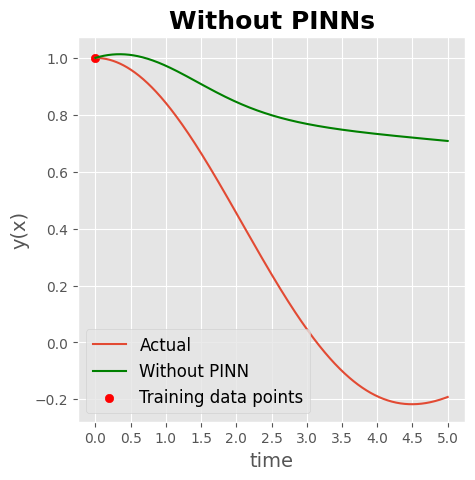

In [ ]:
title_font = {
    "fontsize" : 18,
    "fontweight": "bold"
}

plt.figure(figsize=(5, 5))
plt.style.use("ggplot")
plt.xticks(np.arange(0, 5.5, step=0.5))
plt.title("Without PINNs", title_font)
plt.plot(x, y, label="Actual")
plt.xlabel("time", fontsize=14)
plt.plot(x, y_pred, label="Without PINN", c="g")
plt.ylabel("y(x)", fontsize=14)
plt.scatter(x_data.reshape(-1,), y_data.reshape(-1,), c="r", label="Training data points")
plt.legend(fontsize="large")
plt.show()

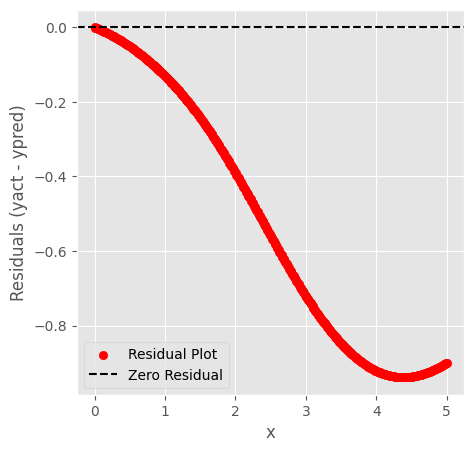

In [ ]:
residuals = y - y_pred
plt.figure(figsize=(5, 5))
plt.scatter(x, residuals, color='r', label='Residual Plot')
plt.axhline(y=0, color='k', linestyle='--', label='Zero Residual')
plt.xlabel('x')
plt.ylabel('Residuals (yact - ypred)')
plt.legend()
plt.show()

In [ ]:
squared_error = (y - y_pred)**2
loss_pred = np.mean(squared_error)
print(loss_pred.item())

0.3923980904772124


<h1>Hyperparamters and Training (With Physics Loss)<h1>

<h1> Defining PINN Model<h1>

In [ ]:
def create_pinn_model(no_hidden_layer,no_hidden_node,no_of_colloc):
  EPOCHS = 20000
  LR = 3e-3

  model = NeuralNetwork(hidden_layers=no_hidden_layer, hidden_nodes=no_hidden_node)
  optim = torch.optim.Adam(model.parameters(),lr=LR)
  scheduler = ReduceLROnPlateau(optim, mode='min', factor=0.1, patience=1000, verbose=True)
  data_loss = nn.MSELoss()
  x_data, y_data, x_physics = create_training_points(no_of_colloc)

  for epoch in range(EPOCHS):
      optim.zero_grad()

      # Compute the "data loss"
      y_pred = model(x_data)
      loss_y = data_loss(y_pred, y_data)

      # Compute the Derivates of the model WRT inputs
      u   = model(x_physics)
      du  = ag.grad(u, x_physics, torch.ones_like(u), create_graph=True)[0]
      ddu = ag.grad(du,  x_physics, torch.ones_like(du),  create_graph=True)[0]

      # BC condition on x=0
      loss_y=loss_y + 0.01*(du[0]**2)

      # Compute the physics loss
      physics = x_physics*ddu + 2*du + u*x_physics
      loss_f = (2e-2)*torch.mean(physics**2)

      # backpropagate joint loss
      loss = loss_y + loss_f # add two loss terms together with equal weight
      loss.backward()
      optim.step()
      scheduler.step(loss)

      if epoch % 1000 == 0:
          print(f"Epochs = {epoch} of {EPOCHS}, Loss = {float(loss):.4e}")
  return model

In [ ]:
model = create_pinn_model(1,32,20)

Epochs = 0 of 20000, Loss = 9.7772e-01
Epochs = 1000 of 20000, Loss = 6.1851e-04
Epochs = 2000 of 20000, Loss = 8.3962e-05
Epochs = 3000 of 20000, Loss = 4.9465e-06
Epochs = 4000 of 20000, Loss = 2.8800e-06
Epochs = 5000 of 20000, Loss = 2.6413e-06
Epochs = 6000 of 20000, Loss = 2.3411e-06
Epochs = 7000 of 20000, Loss = 1.9961e-06
Epochs = 8000 of 20000, Loss = 1.6085e-06
Epochs = 9000 of 20000, Loss = 7.3836e-05
Epochs = 10000 of 20000, Loss = 2.8381e-06
Epochs = 11000 of 20000, Loss = 6.4311e-07
Epochs = 12000 of 20000, Loss = 4.9949e-07
Epochs = 13000 of 20000, Loss = 4.1317e-07
Epochs = 14000 of 20000, Loss = 7.6560e-07
Epochs = 15000 of 20000, Loss = 3.0335e-06
Epochs = 16000 of 20000, Loss = 2.5763e-06
Epochs = 17000 of 20000, Loss = 2.2327e-07
Epochs = 18000 of 20000, Loss = 3.2772e-06
Epochs = 19000 of 20000, Loss = 5.1700e-07


In [ ]:
model.eval()
x = np.linspace(0, 5, 500).reshape(-1, 1)
y = solution(x).reshape(-1, 1)
x_data, y_data, x_physics = create_training_points(20)

y_pred = model(torch.tensor(x, dtype = torch.float32).reshape(-1,1))
y_pred = y_pred.detach().cpu().numpy().reshape(-1,1)

In [ ]:
squared_error = (y - y_pred)**2
loss_pred = np.mean(squared_error)
print(loss_pred.item())

6.037367674502217e-06


In [ ]:
def create_graph_1(no_colloc_points,no_of_neuron,no_of_hidden_layer,x,x_data,y,y_data,y_prediction,x_physics):

  title_font = {
      "fontsize" : 18,
      "fontweight": "bold"
  }

  plt.figure(figsize=(5, 5))
  plt.style.use("ggplot")
  plt.xticks(np.arange(0, 7.5, step=0.5))
  plt.title(f"{no_colloc_points} Collocation Points,{no_of_neuron} Neurons each in {no_of_hidden_layer} hidden layer", title_font)
  plt.plot(x, y, label="Actual")
  plt.scatter(x_physics, -0*(x_physics), s=30, color="tab:blue", alpha=0.4, label='Collocation points')
  plt.xlabel("time", fontsize=14)
  plt.plot(x, y_prediction, label="PINN", c="g")
  plt.ylabel("u(t)", fontsize=14)
  plt.scatter(x_data.reshape(-1,), y_data.reshape(-1,), c="r", label="Training data points")
  plt.legend(fontsize="large")
  plt.show()

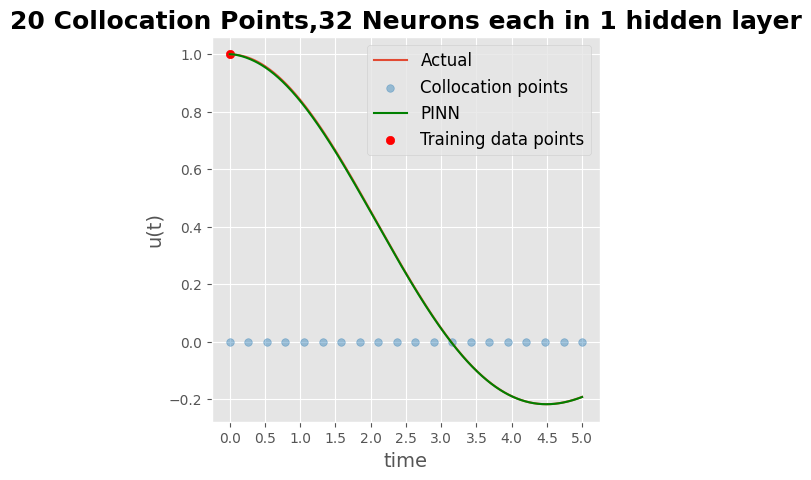

In [ ]:
create_graph_1(20,32,1,x,x_data,y,y_data,y_pred,x_physics.detach().numpy())

In [ ]:
def create_graph_2(x,y_prediction):
  residuals = y - y_prediction
  plt.figure(figsize=(5, 5))
  plt.scatter(x, residuals, color='r', label='Residual Plot')
  plt.axhline(y=0, color='k', linestyle='--', label='Zero Residual')
  plt.xlabel('x')
  plt.ylabel('Residuals (yact - ypred)')
  plt.legend()
  plt.show()

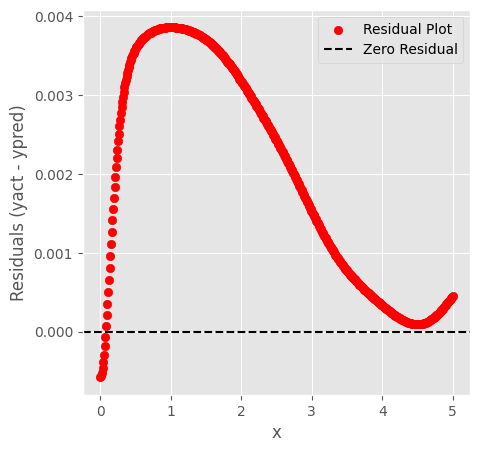

In [ ]:
create_graph_2(x,y_pred)

<h1> From the above results, PINNs obviously generate better results when dealing with differential equations, however we can also analyse the effect of architecture on results of PINNs<h1>



<h1> 2. Varying the number of neurons in each layer

<h1> 2.1 Nh = 1, N = 16, Nc= 20 </h1>

In [ ]:
model = create_pinn_model(1,16,20)

Epochs = 0 of 20000, Loss = 5.2517e-01
Epochs = 1000 of 20000, Loss = 6.8650e-04
Epochs = 2000 of 20000, Loss = 4.1525e-05
Epochs = 3000 of 20000, Loss = 4.2206e-06
Epochs = 4000 of 20000, Loss = 5.3187e-07
Epochs = 5000 of 20000, Loss = 2.7611e-06
Epochs = 6000 of 20000, Loss = 1.1732e-05
Epochs = 7000 of 20000, Loss = 3.3898e-07
Epochs = 8000 of 20000, Loss = 5.9309e-07
Epochs = 9000 of 20000, Loss = 1.6359e-06
Epochs = 10000 of 20000, Loss = 2.3333e-07
Epochs = 11000 of 20000, Loss = 2.6065e-07
Epochs = 12000 of 20000, Loss = 2.4933e-05
Epochs = 13000 of 20000, Loss = 1.4719e-07
Epochs = 14000 of 20000, Loss = 5.8594e-07
Epochs = 15000 of 20000, Loss = 6.5075e-08
Epochs = 16000 of 20000, Loss = 3.2085e-06
Epochs = 17000 of 20000, Loss = 1.2104e-07
Epochs = 18000 of 20000, Loss = 2.7025e-08
Epochs = 19000 of 20000, Loss = 8.6672e-09


In [ ]:
model.eval()
x = np.linspace(0, 5, 500).reshape(-1, 1)
y = solution(x).reshape(-1, 1)
x_data, y_data, x_physics = create_training_points(20)
y_pred = model(torch.tensor(x, dtype = torch.float32).reshape(-1,1))
y_pred = y_pred.detach().cpu().numpy().reshape(-1,1)

In [ ]:
squared_error = (y - y_pred)**2
loss_pred = np.mean(squared_error)
print(loss_pred.item())

1.8105512629824285e-06


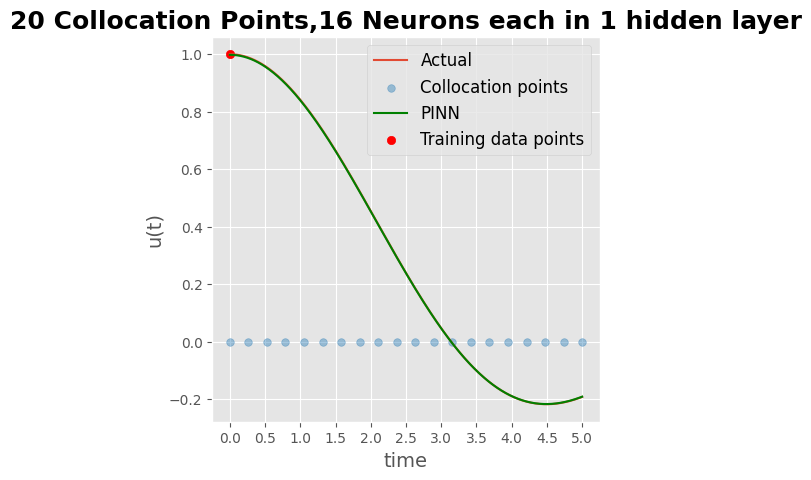

In [ ]:
create_graph_1(20,16,1,x,x_data,y,y_data,y_pred,x_physics.detach().numpy())

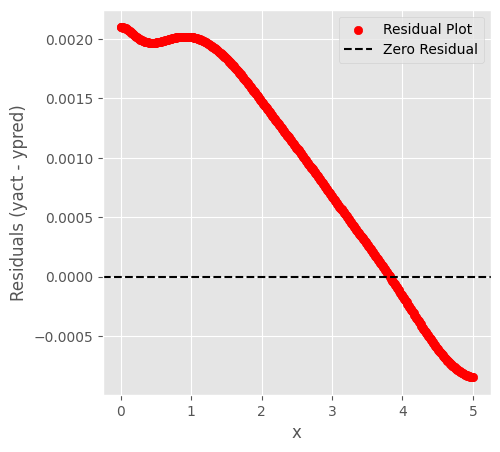

In [ ]:
create_graph_2(x,y_pred)

<h1> 2.2 Nh = 1, N = 20, Nc= 20 </h1>

In [ ]:
model = create_pinn_model(1,20,20)

Epochs = 0 of 20000, Loss = 9.3899e-01
Epochs = 1000 of 20000, Loss = 9.1912e-04
Epochs = 2000 of 20000, Loss = 1.7078e-04
Epochs = 3000 of 20000, Loss = 4.8968e-06
Epochs = 4000 of 20000, Loss = 2.1873e-06
Epochs = 5000 of 20000, Loss = 2.4434e-06
Epochs = 6000 of 20000, Loss = 9.0707e-07
Epochs = 7000 of 20000, Loss = 6.1623e-05
Epochs = 8000 of 20000, Loss = 5.1612e-07
Epochs = 9000 of 20000, Loss = 6.9927e-05
Epochs = 10000 of 20000, Loss = 2.9295e-07
Epochs = 11000 of 20000, Loss = 1.8825e-07
Epochs = 12000 of 20000, Loss = 1.1268e-05
Epochs = 13000 of 20000, Loss = 4.6304e-08
Epochs = 14000 of 20000, Loss = 3.5223e-08
Epochs = 15000 of 20000, Loss = 1.1597e-06
Epochs = 16000 of 20000, Loss = 3.3993e-05
Epochs = 17000 of 20000, Loss = 2.2744e-08
Epochs = 18000 of 20000, Loss = 2.7876e-08
Epoch 18277: reducing learning rate of group 0 to 3.0000e-04.
Epochs = 19000 of 20000, Loss = 2.4555e-08
Epoch 19278: reducing learning rate of group 0 to 3.0000e-05.


In [ ]:
model.eval()
x = np.linspace(0, 5, 500).reshape(-1, 1)
y = solution(x).reshape(-1, 1)
x_data, y_data, x_physics = create_training_points(20)
y_pred = model(torch.tensor(x, dtype = torch.float32).reshape(-1,1))
y_pred = y_pred.detach().cpu().numpy().reshape(-1,1)

In [ ]:
squared_error = (y - y_pred)**2
loss_pred = np.mean(squared_error)
print(loss_pred.item())

9.171677565441502e-07


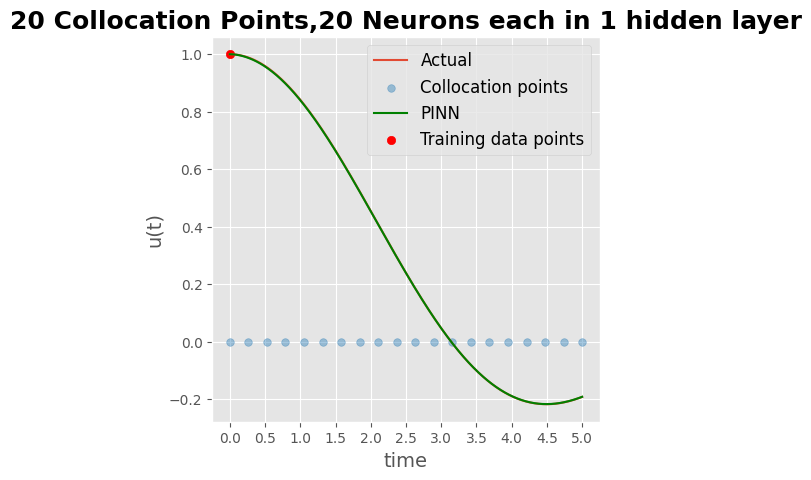

In [ ]:
create_graph_1(20,20,1,x,x_data,y,y_data,y_pred,x_physics.detach().numpy())

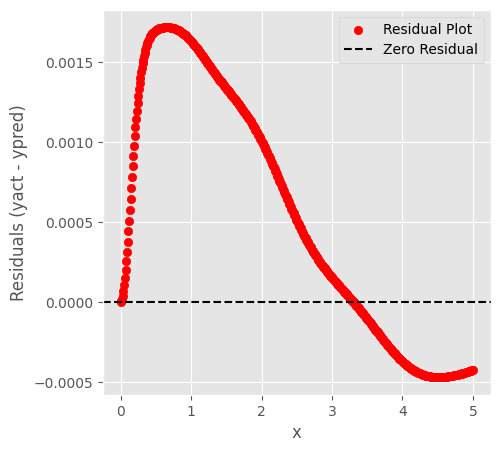

In [ ]:
create_graph_2(x,y_pred)

<h1> 2.3 Nh = 1, N = 24, Nc= 20 </h1>

In [ ]:
model = create_pinn_model(1,24,20)

Epochs = 0 of 20000, Loss = 9.5092e-01
Epochs = 1000 of 20000, Loss = 7.8183e-04
Epochs = 2000 of 20000, Loss = 1.6775e-04
Epochs = 3000 of 20000, Loss = 5.2915e-06
Epochs = 4000 of 20000, Loss = 5.8335e-06
Epochs = 5000 of 20000, Loss = 1.4973e-05
Epochs = 6000 of 20000, Loss = 1.7632e-07
Epochs = 7000 of 20000, Loss = 1.1686e-07
Epochs = 8000 of 20000, Loss = 4.0572e-06
Epochs = 9000 of 20000, Loss = 7.1701e-08
Epochs = 10000 of 20000, Loss = 3.0077e-08
Epochs = 11000 of 20000, Loss = 2.5662e-07
Epoch 11453: reducing learning rate of group 0 to 3.0000e-04.
Epochs = 12000 of 20000, Loss = 2.7664e-08
Epoch 12454: reducing learning rate of group 0 to 3.0000e-05.
Epochs = 13000 of 20000, Loss = 2.5622e-08
Epochs = 14000 of 20000, Loss = 2.5148e-08
Epochs = 15000 of 20000, Loss = 2.4520e-08
Epochs = 16000 of 20000, Loss = 2.3732e-08
Epochs = 17000 of 20000, Loss = 2.2776e-08
Epochs = 18000 of 20000, Loss = 2.1571e-08
Epochs = 19000 of 20000, Loss = 1.9912e-08


In [ ]:
model.eval()
x = np.linspace(0, 5, 500).reshape(-1, 1)
y = solution(x).reshape(-1, 1)
x_data, y_data, x_physics = create_training_points(20)
y_pred = model(torch.tensor(x, dtype = torch.float32).reshape(-1,1))
y_pred = y_pred.detach().cpu().numpy().reshape(-1,1)

In [ ]:
squared_error = (y - y_pred)**2
loss_pred = np.mean(squared_error)
print(loss_pred.item())

1.5467848589992658e-08


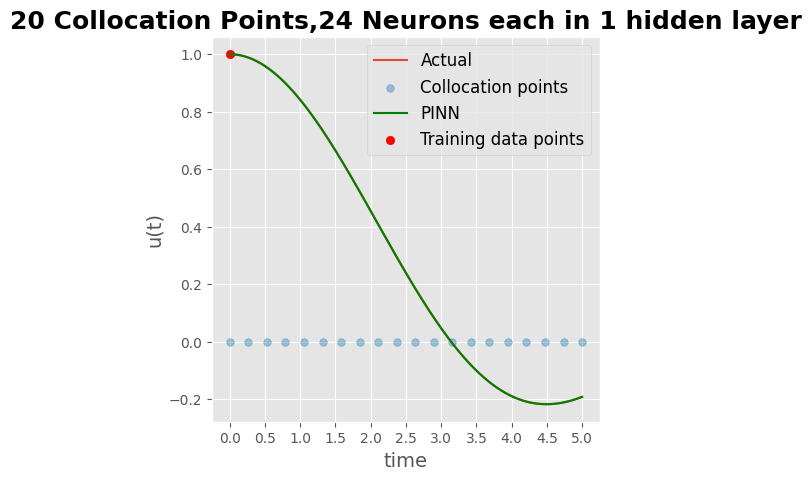

In [ ]:
create_graph_1(20,24,1,x,x_data,y,y_data,y_pred,x_physics.detach().numpy())

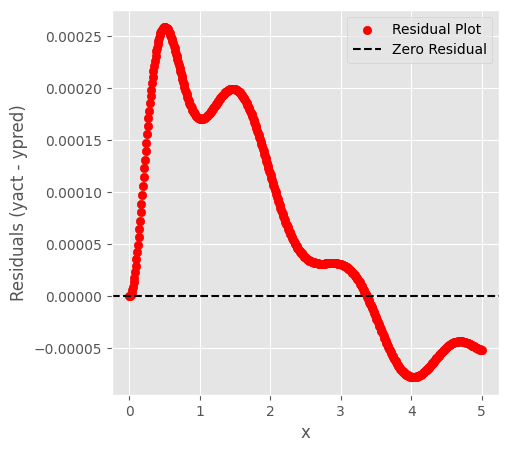

In [ ]:
create_graph_2(x,y_pred)

<h1> 2.4 Nh = 1, N = 28, Nc= 20 </h1>

In [ ]:
model = create_pinn_model(1,28,20)

Epochs = 0 of 20000, Loss = 1.0584e+00
Epochs = 1000 of 20000, Loss = 6.7688e-04
Epochs = 2000 of 20000, Loss = 8.4122e-05
Epochs = 3000 of 20000, Loss = 5.6479e-06
Epochs = 4000 of 20000, Loss = 2.4474e-06
Epochs = 5000 of 20000, Loss = 2.2843e-04
Epochs = 6000 of 20000, Loss = 1.0371e-06
Epochs = 7000 of 20000, Loss = 7.8451e-07
Epochs = 8000 of 20000, Loss = 6.0822e-07
Epochs = 9000 of 20000, Loss = 7.0410e-07
Epochs = 10000 of 20000, Loss = 4.0487e-07
Epochs = 11000 of 20000, Loss = 2.7467e-07
Epochs = 12000 of 20000, Loss = 2.4303e-07
Epochs = 13000 of 20000, Loss = 2.1300e-07
Epochs = 14000 of 20000, Loss = 1.9589e-07
Epochs = 15000 of 20000, Loss = 2.0224e-07
Epochs = 16000 of 20000, Loss = 6.8628e-06
Epochs = 17000 of 20000, Loss = 5.2715e-06
Epochs = 18000 of 20000, Loss = 2.8677e-07
Epochs = 19000 of 20000, Loss = 1.0374e-07


In [ ]:
model.eval()
x = np.linspace(0, 5, 500).reshape(-1, 1)
y = solution(x).reshape(-1, 1)
x_data, y_data, x_physics = create_training_points(20)
y_pred = model(torch.tensor(x, dtype = torch.float32).reshape(-1,1))
y_pred = y_pred.detach().cpu().numpy().reshape(-1,1)

In [ ]:
squared_error = (y - y_pred)**2
loss_pred = np.mean(squared_error)
print(loss_pred.item())

1.5989315839424286e-07


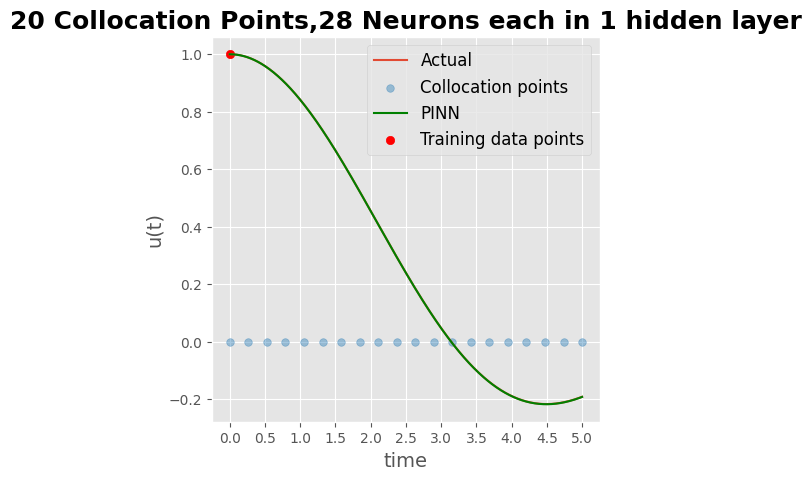

In [ ]:
create_graph_1(20,28,1,x,x_data,y,y_data,y_pred,x_physics.detach().numpy())

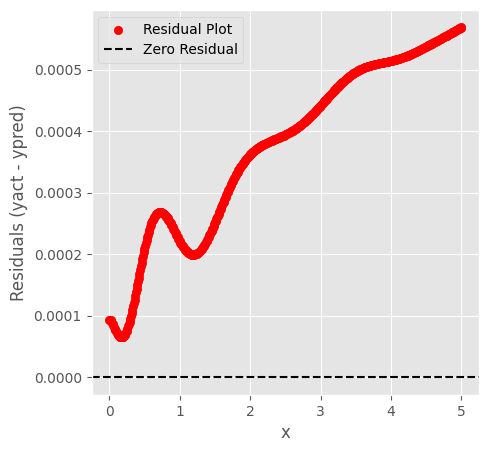

In [ ]:
create_graph_2(x,y_pred)

<h1>2.5 Conclusion</h1>

20 Collocation points, 1 Hidden Layer:

<ul>
<li>16 Neurons: 1.8105512629824285e-06</li>
<li>20 Neurons: 9.171677565441502e-07</li>
<li>24 Neurons: 1.5467848589992658e-08</li>
<li>28 Neurons: 1.5989315839424286e-07</li>
</ul>

Therefore, 24 neurons seems to the better option. So we'll continue with 24 Neurons

<h1> 3. Varying the number of collocation points </h1>

<h1>3.1 Nh = 1, N = 24, Nc= 10<h1>

In [ ]:
model = create_pinn_model(1,24,10)

Epochs = 0 of 20000, Loss = 4.6041e-01
Epochs = 1000 of 20000, Loss = 4.1531e-04
Epochs = 2000 of 20000, Loss = 9.1326e-06
Epochs = 3000 of 20000, Loss = 1.3255e-06
Epochs = 4000 of 20000, Loss = 3.4086e-07
Epochs = 5000 of 20000, Loss = 2.4091e-07
Epochs = 6000 of 20000, Loss = 2.1901e-07
Epochs = 7000 of 20000, Loss = 1.0634e-05
Epochs = 8000 of 20000, Loss = 2.0365e-07
Epochs = 9000 of 20000, Loss = 1.6410e-07
Epochs = 10000 of 20000, Loss = 4.4080e-07
Epochs = 11000 of 20000, Loss = 1.3534e-07
Epochs = 12000 of 20000, Loss = 1.1091e-07
Epochs = 13000 of 20000, Loss = 5.4349e-08
Epochs = 14000 of 20000, Loss = 4.0109e-08
Epochs = 15000 of 20000, Loss = 1.7609e-07
Epochs = 16000 of 20000, Loss = 8.1088e-08
Epochs = 17000 of 20000, Loss = 3.4734e-09
Epochs = 18000 of 20000, Loss = 3.0444e-09
Epochs = 19000 of 20000, Loss = 3.6790e-07


In [ ]:
model.eval()
x = np.linspace(0, 5, 500).reshape(-1, 1)
y = solution(x).reshape(-1, 1)
x_data, y_data, x_physics = create_training_points(20)
y_pred = model(torch.tensor(x, dtype = torch.float32).reshape(-1,1))
y_pred = y_pred.detach().cpu().numpy().reshape(-1,1)

In [ ]:
squared_error = (y - y_pred)**2
loss_pred = np.mean(squared_error)
print(loss_pred.item())

2.556867539511037e-05


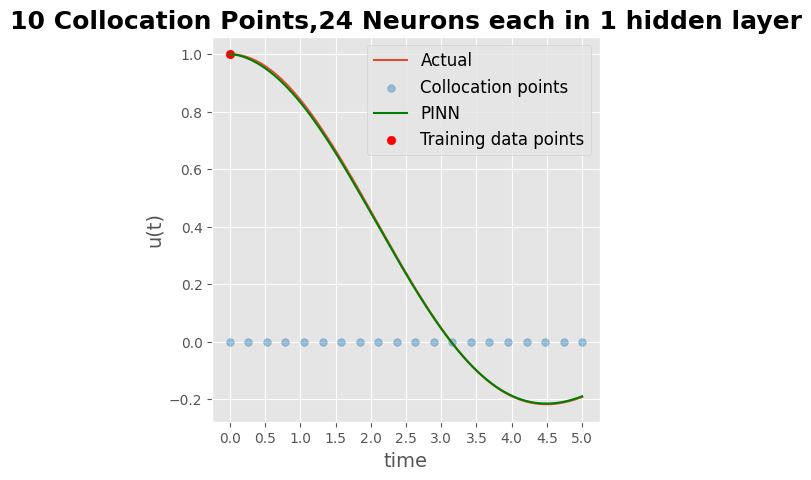

In [ ]:
create_graph_1(10,24,1,x,x_data,y,y_data,y_pred,x_physics.detach().numpy())

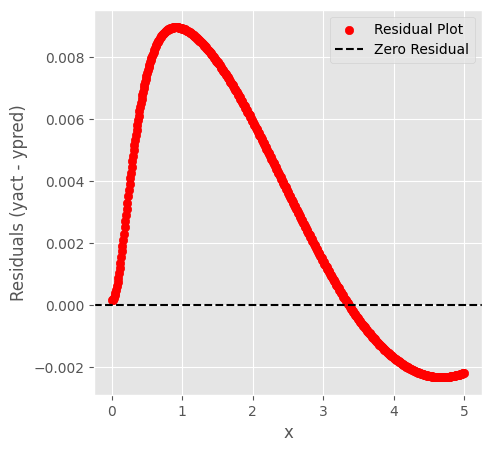

In [ ]:
create_graph_2(x,y_pred)

<h1>3.2 Nh = 1, N = 24, Nc= 15<h1>

In [ ]:
model = create_pinn_model(1,24,15)

Epochs = 0 of 20000, Loss = 1.2154e+00
Epochs = 1000 of 20000, Loss = 9.5352e-04
Epochs = 2000 of 20000, Loss = 1.6764e-04
Epochs = 3000 of 20000, Loss = 1.2843e-05
Epochs = 4000 of 20000, Loss = 2.0734e-06
Epochs = 5000 of 20000, Loss = 1.0690e-06
Epochs = 6000 of 20000, Loss = 6.3135e-07
Epochs = 7000 of 20000, Loss = 6.5855e-07
Epochs = 8000 of 20000, Loss = 4.6842e-07
Epochs = 9000 of 20000, Loss = 4.8095e-04
Epochs = 10000 of 20000, Loss = 3.8669e-07
Epochs = 11000 of 20000, Loss = 3.4895e-07
Epochs = 12000 of 20000, Loss = 4.2071e-07
Epochs = 13000 of 20000, Loss = 3.1881e-07
Epochs = 14000 of 20000, Loss = 3.0827e-07
Epochs = 15000 of 20000, Loss = 2.7313e-07
Epochs = 16000 of 20000, Loss = 3.2737e-07
Epochs = 17000 of 20000, Loss = 2.4102e-07
Epochs = 18000 of 20000, Loss = 2.2175e-07
Epochs = 19000 of 20000, Loss = 1.3802e-06


In [ ]:
model.eval()
x = np.linspace(0, 5, 500).reshape(-1, 1)
y = solution(x).reshape(-1, 1)
x_data, y_data, x_physics = create_training_points(20)
y_pred = model(torch.tensor(x, dtype = torch.float32).reshape(-1,1))
y_pred = y_pred.detach().cpu().numpy().reshape(-1,1)

In [ ]:
squared_error = (y - y_pred)**2
loss_pred = np.mean(squared_error)
print(loss_pred.item())

1.512427437759297e-06


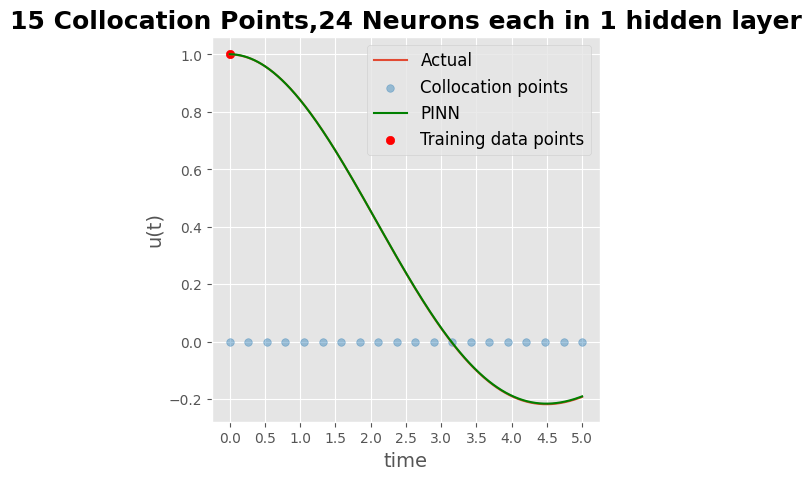

In [ ]:
create_graph_1(15,24,1,x,x_data,y,y_data,y_pred,x_physics.detach().numpy())

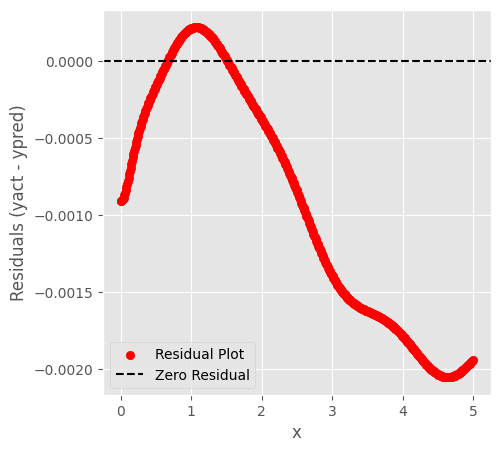

In [ ]:
create_graph_2(x,y_pred)

<h1>3.3 Nh = 1, N = 24, Nc= 25<h1>

In [ ]:
model = create_pinn_model(1,24,25)

Epochs = 0 of 20000, Loss = 7.6902e-01
Epochs = 1000 of 20000, Loss = 5.6507e-04
Epochs = 2000 of 20000, Loss = 1.1920e-05
Epochs = 3000 of 20000, Loss = 1.3187e-06
Epochs = 4000 of 20000, Loss = 1.0500e-05
Epochs = 5000 of 20000, Loss = 2.6375e-07
Epochs = 6000 of 20000, Loss = 1.9825e-07
Epochs = 7000 of 20000, Loss = 1.8060e-07
Epochs = 8000 of 20000, Loss = 7.0063e-07
Epochs = 9000 of 20000, Loss = 5.3772e-08
Epochs = 10000 of 20000, Loss = 3.6919e-08
Epochs = 11000 of 20000, Loss = 1.4534e-05
Epochs = 12000 of 20000, Loss = 2.4907e-05
Epoch 12529: reducing learning rate of group 0 to 3.0000e-04.
Epochs = 13000 of 20000, Loss = 2.9177e-08
Epoch 13530: reducing learning rate of group 0 to 3.0000e-05.
Epochs = 14000 of 20000, Loss = 2.8745e-08
Epoch 14531: reducing learning rate of group 0 to 3.0000e-06.
Epochs = 15000 of 20000, Loss = 2.8691e-08
Epoch 15532: reducing learning rate of group 0 to 3.0000e-07.
Epochs = 16000 of 20000, Loss = 2.8687e-08
Epoch 16533: reducing learning rat

In [ ]:
model.eval()
x = np.linspace(0, 5, 500).reshape(-1, 1)
y = solution(x).reshape(-1, 1)
x_data, y_data, x_physics = create_training_points(20)
y_pred = model(torch.tensor(x, dtype = torch.float32).reshape(-1,1))
y_pred = y_pred.detach().cpu().numpy().reshape(-1,1)

In [ ]:
squared_error = (y - y_pred)**2
loss_pred = np.mean(squared_error)
print(loss_pred.item())

7.136539132118726e-07


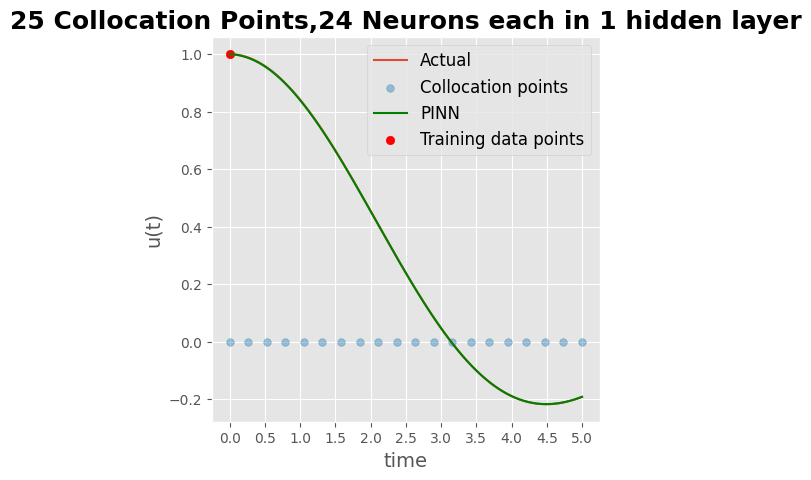

In [ ]:
create_graph_1(25,24,1,x,x_data,y,y_data,y_pred,x_physics.detach().numpy())

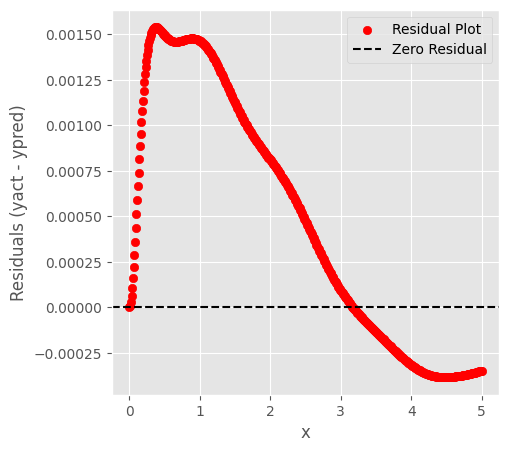

In [ ]:
create_graph_2(x,y_pred)

<h1>3.4 Conclusion </h1>


24 Neurons, 1 Hidden Layer:

<ul>
<li>10 Collocation Points: 2.556867539511037e-05</li>
<li>15 Collocation Points: 1.512427437759297e-06</li>
<li>20 Collocation Points: 1.5467848589992658e-08</li>
<li>24 Collocation Points: 7.136539132118726e-07</li>
</ul>

Therefore, 20 collocation points is the better option. So we'll continue with 20 Collocation points.

<h1>4. Varying the number of hidden layers</h1>

<h1>4.1 Nh = 3, N = 24, Nc= 20</h1>

In [ ]:
model = create_pinn_model(3,24,20)

Epochs = 0 of 20000, Loss = 8.8284e-01
Epochs = 1000 of 20000, Loss = 9.9351e-04
Epochs = 2000 of 20000, Loss = 1.0992e-05
Epochs = 3000 of 20000, Loss = 2.2980e-06
Epochs = 4000 of 20000, Loss = 1.7773e-06
Epochs = 5000 of 20000, Loss = 1.0639e-06
Epochs = 6000 of 20000, Loss = 5.7070e-07
Epochs = 7000 of 20000, Loss = 5.5458e-07
Epochs = 8000 of 20000, Loss = 4.9206e-07
Epochs = 9000 of 20000, Loss = 4.2450e-07
Epochs = 10000 of 20000, Loss = 8.1125e-07
Epochs = 11000 of 20000, Loss = 1.5124e-07
Epochs = 12000 of 20000, Loss = 4.8230e-07
Epochs = 13000 of 20000, Loss = 3.7508e-08
Epochs = 14000 of 20000, Loss = 3.4703e-06
Epochs = 15000 of 20000, Loss = 7.1007e-06
Epochs = 16000 of 20000, Loss = 1.5469e-08
Epoch 16259: reducing learning rate of group 0 to 3.0000e-04.
Epochs = 17000 of 20000, Loss = 1.1120e-08
Epochs = 18000 of 20000, Loss = 5.7532e-09
Epochs = 19000 of 20000, Loss = 3.3375e-09


In [ ]:
model.eval()
x = np.linspace(0, 5, 500).reshape(-1, 1)
y = solution(x).reshape(-1, 1)
x_data, y_data, x_physics = create_training_points(20)
y_pred = model(torch.tensor(x, dtype = torch.float32).reshape(-1,1))
y_pred = y_pred.detach().cpu().numpy().reshape(-1,1)

In [ ]:
squared_error = (y - y_pred)**2
loss_pred = np.mean(squared_error)
print(loss_pred.item())

1.12428577419504e-07


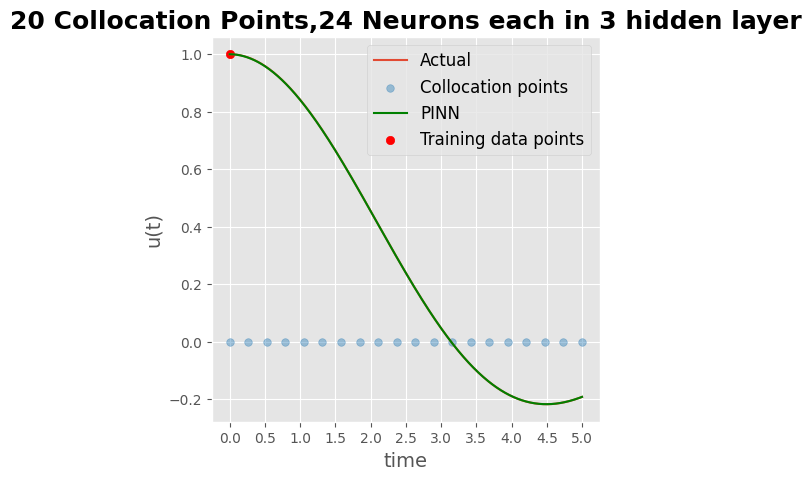

In [ ]:
create_graph_1(20,24,3,x,x_data,y,y_data,y_pred,x_physics.detach().numpy())

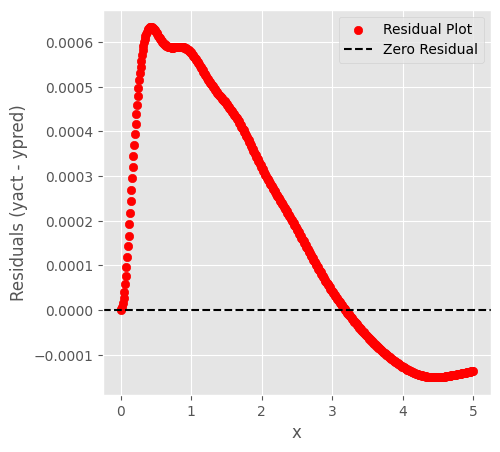

In [ ]:
create_graph_2(x,y_pred)

<h1>4.2 Nh = 5, N = 24, Nc= 20</h1>

In [ ]:
model = create_pinn_model(5,24,20)

Epochs = 0 of 20000, Loss = 1.3581e+00
Epochs = 1000 of 20000, Loss = 1.4293e-04
Epochs = 2000 of 20000, Loss = 5.9084e-07
Epochs = 3000 of 20000, Loss = 2.3003e-07
Epochs = 4000 of 20000, Loss = 1.5514e-07
Epochs = 5000 of 20000, Loss = 1.1793e-07
Epochs = 6000 of 20000, Loss = 1.7372e-07
Epochs = 7000 of 20000, Loss = 9.9918e-07
Epochs = 8000 of 20000, Loss = 3.9776e-08
Epochs = 9000 of 20000, Loss = 9.1163e-08
Epochs = 10000 of 20000, Loss = 1.3412e-08
Epochs = 11000 of 20000, Loss = 1.7086e-06
Epoch 11250: reducing learning rate of group 0 to 3.0000e-04.
Epochs = 12000 of 20000, Loss = 1.3111e-08
Epoch 12251: reducing learning rate of group 0 to 3.0000e-05.
Epochs = 13000 of 20000, Loss = 1.2860e-08
Epoch 13252: reducing learning rate of group 0 to 3.0000e-06.
Epochs = 14000 of 20000, Loss = 1.2828e-08
Epoch 14253: reducing learning rate of group 0 to 3.0000e-07.
Epochs = 15000 of 20000, Loss = 1.2829e-08
Epoch 15254: reducing learning rate of group 0 to 3.0000e-08.
Epochs = 16000 

In [ ]:
model.eval()
x = np.linspace(0, 5, 500).reshape(-1, 1)
y = solution(x).reshape(-1, 1)
x_data, y_data, x_physics = create_training_points(20)
y_pred = model(torch.tensor(x, dtype = torch.float32).reshape(-1,1))
y_pred = y_pred.detach().cpu().numpy().reshape(-1,1)

In [ ]:
squared_error = (y - y_pred)**2
loss_pred = np.mean(squared_error)
print(loss_pred.item())

2.1240499890530363e-09


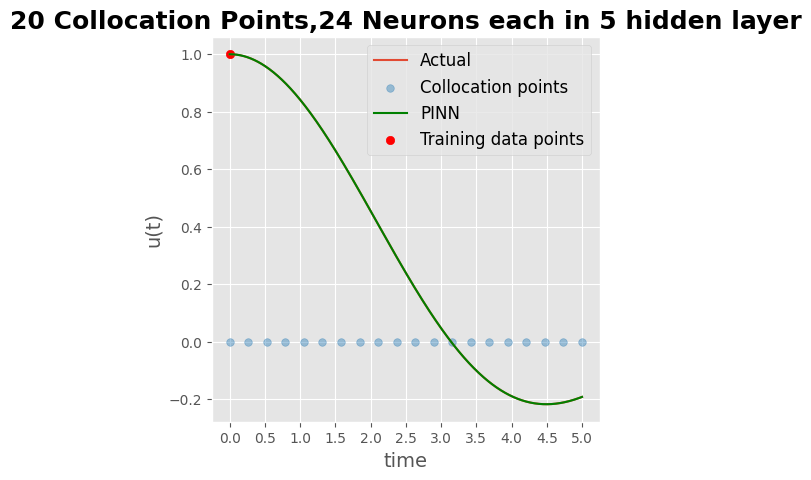

In [ ]:
create_graph_1(20,24,5,x,x_data,y,y_data,y_pred,x_physics.detach().numpy())

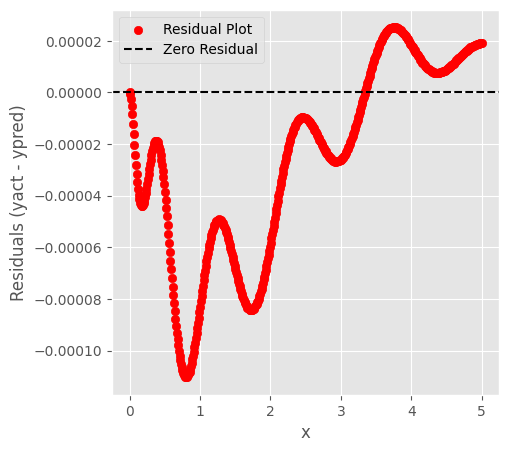

In [ ]:
create_graph_2(x,y_pred)

<h1>4.3 Conclusion</h1>

24 Neurons, 20 Collocation Points:

<ul>
<li>1 Hidden Layer: 1.5467848589992658e-08</li>
<li>3 Hidden Layer: 1.12428577419504e-07</li>
<li>5 Hidden Layer: 2.1240499890530363e-09</li>
</ul>

Therefore, 5 hidden layers seems to the better option. So we'll continue with 5 hidden layers.

<h1>Best Possible Architecture</h1>

1.   Number Of Collocation Points - 20
2.   Number Of Neurons in Each Layer - 24
3.   Number Of Hidden Layers - 5

<b>Error - 2.1240499890530363e-09</b>



<h1>5. New Trainable Parameter</h1>

<p> Till Now the combined loss function was loss = (2e-2)*loss_p + loss_d where loss_p
denotes physical loss (collocation points) and loss_d denotes MSE loss (training points).</p>

<p> This was done as written in the paper, but we can try to find an optimal weight to be given to loss_p (physical loss)

<p> What we can do is introduce a trainable parameter k such that the new loss function is loss = k*loss_p + loss_d, that is we are varying the weight given to physical loss to determine how much importance it should be given.</p>

In [ ]:
x = np.linspace(0, 5, 500).reshape(-1, 1)  #Training Points
y = solution(x).reshape(-1, 1)

x_data = x[0:300:300] # Reducing the training points
y_data = y[0:300:300]
y_data[0] = 1

x_data = torch.tensor(x_data, dtype=torch.float32)
y_data = torch.tensor(y_data, dtype=torch.float32)

x_physics = torch.linspace(0, 5, 20, requires_grad=True, dtype=torch.float32).reshape(-1, 1) #20 Collocation Points

In [ ]:
# !pip install --quiet optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 13.8 MB/s eta 0:00:00


<h1> Random Search <h1>

<p> Using optuna for implementing random search for trying to find optimal value of k. We limit our trials to 10, but can be increased to find a better k value.

In [ ]:
import optuna

# The objective function which we want to optimize
def objective(trial):
    EPOCHS = 20000
    LR = 3e-3

    no_hidden_layer = 5  # Number of hidden layers
    no_hidden_node = 24  # Number of hidden nodes

    k = trial.suggest_loguniform('k', 3e-3,3e-1)  # Random search for k between 3e-3 and 3e-1

    model = NeuralNetwork(hidden_layers=no_hidden_layer, hidden_nodes=no_hidden_node)
    optim = torch.optim.Adam(model.parameters(),lr=LR)
    scheduler = ReduceLROnPlateau(optim, mode='min', factor=0.1, patience=1000, verbose=True)
    data_loss = nn.MSELoss()

    for epoch in range(EPOCHS):
      optim.zero_grad()

      # Compute the "data loss"
      y_pred = model(x_data)
      loss_y = data_loss(y_pred, y_data)

      # Compute the Derivates of the model WRT inputs
      u   = model(x_physics)
      du  = ag.grad(u, x_physics, torch.ones_like(u), create_graph=True)[0]
      ddu = ag.grad(du,  x_physics, torch.ones_like(du),  create_graph=True)[0]

      # BC condition on x=0
      loss_y=loss_y + 0.01*(du[0]**2)

      # Compute the physics loss
      physics = x_physics*ddu + 2*du + u*x_physics
      loss_f = (2e-2)*torch.mean(physics**2)

      # backpropagate joint loss
      loss = loss_y + k*loss_f
      loss.backward()
      optim.step()
      scheduler.step(loss)

    # Return the loss which we want to optimize
    return float(loss)

if __name__ == '__main__':
    study = optuna.create_study(direction='minimize')  # Minimize the objective function
    study.optimize(objective, n_trials=10)  # Adjust the number of trials as needed

    best_trial = study.best_trial
    best_k = best_trial.params['k']
    best_loss = best_trial.value

    print("Best k:", best_k)
    print("Best Loss:", best_loss)


[I 2023-11-08 19:17:41,833] A new study created in memory with name: no-name-972450d2-9e1f-4822-ab28-295a57767897
<ipython-input-326-533b6fd357e1>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  k = trial.suggest_loguniform('k', 3e-3,3e-1)  # Random search for k between 3e-3 and 3e-1
[I 2023-11-08 19:19:05,622] Trial 0 finished with value: 1.243315779220211e-07 and parameters: {'k': 0.009420851115944165}. Best is trial 0 with value: 1.243315779220211e-07.


Epoch 19679: reducing learning rate of group 0 to 3.0000e-04.


[I 2023-11-08 19:20:30,251] Trial 1 finished with value: 5.5429913992099955e-09 and parameters: {'k': 0.009439205157436244}. Best is trial 1 with value: 5.5429913992099955e-09.


Epoch 13827: reducing learning rate of group 0 to 3.0000e-04.
Epoch 14828: reducing learning rate of group 0 to 3.0000e-05.
Epoch 15829: reducing learning rate of group 0 to 3.0000e-06.
Epoch 16830: reducing learning rate of group 0 to 3.0000e-07.
Epoch 17831: reducing learning rate of group 0 to 3.0000e-08.
Epoch 18832: reducing learning rate of group 0 to 3.0000e-09.


[I 2023-11-08 19:21:53,655] Trial 2 finished with value: 2.6360398308611366e-09 and parameters: {'k': 0.0043629376881363915}. Best is trial 2 with value: 2.6360398308611366e-09.


Epoch 08394: reducing learning rate of group 0 to 3.0000e-04.
Epoch 09395: reducing learning rate of group 0 to 3.0000e-05.
Epoch 10396: reducing learning rate of group 0 to 3.0000e-06.
Epoch 11397: reducing learning rate of group 0 to 3.0000e-07.
Epoch 12398: reducing learning rate of group 0 to 3.0000e-08.
Epoch 13399: reducing learning rate of group 0 to 3.0000e-09.


[I 2023-11-08 19:23:18,232] Trial 3 finished with value: 1.0690158092074853e-08 and parameters: {'k': 0.03633465297579029}. Best is trial 2 with value: 2.6360398308611366e-09.


Epoch 08910: reducing learning rate of group 0 to 3.0000e-04.


[I 2023-11-08 19:24:42,215] Trial 4 finished with value: 5.9656475315250646e-09 and parameters: {'k': 0.04094111352575921}. Best is trial 2 with value: 2.6360398308611366e-09.


Epoch 13577: reducing learning rate of group 0 to 3.0000e-04.
Epoch 14578: reducing learning rate of group 0 to 3.0000e-05.
Epoch 15579: reducing learning rate of group 0 to 3.0000e-06.
Epoch 16580: reducing learning rate of group 0 to 3.0000e-07.
Epoch 17581: reducing learning rate of group 0 to 3.0000e-08.
Epoch 18582: reducing learning rate of group 0 to 3.0000e-09.


[I 2023-11-08 19:26:06,083] Trial 5 finished with value: 7.812339219981368e-09 and parameters: {'k': 0.04739825450478639}. Best is trial 2 with value: 2.6360398308611366e-09.
[I 2023-11-08 19:27:30,144] Trial 6 finished with value: 6.790232376374661e-09 and parameters: {'k': 0.03751125497568488}. Best is trial 2 with value: 2.6360398308611366e-09.


Epoch 16746: reducing learning rate of group 0 to 3.0000e-04.


[I 2023-11-08 19:28:53,470] Trial 7 finished with value: 1.2133662075086704e-08 and parameters: {'k': 0.09828922339146802}. Best is trial 2 with value: 2.6360398308611366e-09.


Epoch 09964: reducing learning rate of group 0 to 3.0000e-04.
Epoch 10965: reducing learning rate of group 0 to 3.0000e-05.
Epoch 11966: reducing learning rate of group 0 to 3.0000e-06.
Epoch 12967: reducing learning rate of group 0 to 3.0000e-07.
Epoch 13968: reducing learning rate of group 0 to 3.0000e-08.
Epoch 14969: reducing learning rate of group 0 to 3.0000e-09.


[I 2023-11-08 19:30:17,916] Trial 8 finished with value: 5.352645437994852e-09 and parameters: {'k': 0.0698210212139948}. Best is trial 2 with value: 2.6360398308611366e-09.


Epoch 17259: reducing learning rate of group 0 to 3.0000e-04.
Epoch 18260: reducing learning rate of group 0 to 3.0000e-05.
Epoch 19261: reducing learning rate of group 0 to 3.0000e-06.


[I 2023-11-08 19:31:41,063] Trial 9 finished with value: 1.2378625902087492e-09 and parameters: {'k': 0.1628484766196741}. Best is trial 9 with value: 1.2378625902087492e-09.


Best k: 0.1628484766196741
Best Loss: 1.2378625902087492e-09


We get that the optimal value of k is 0.163, we now model this separately and visually observe the results.

<h1>6. Final Model </h1>

<ul>
<li> Neurons: 24 </li>
<li> Hidden Layers: 5</li>
<li> Collocation Points: 20</li>
<li> k = 0.163 </li>
</ul>

Let's test this hyperparameters and calculate the final error.

In [ ]:
x = np.linspace(0, 5, 500).reshape(-1, 1)  #Training Points
y = solution(x).reshape(-1, 1)

x_data = x[0:300:30] #Reducing the training points
y_data = y[0:300:30]

x_data = torch.tensor(x_data, dtype=torch.float32)
y_data = torch.tensor(y_data, dtype=torch.float32)

x_physics = torch.linspace(0, 5, 20, requires_grad=True, dtype=torch.float32).reshape(-1, 1) #20 Collocation Points

In [ ]:
EPOCHS = 20000
LR = 3e-3

model = NeuralNetwork(hidden_layers=5, hidden_nodes=24)
optim = torch.optim.Adam(model.parameters(),lr=LR)
scheduler = ReduceLROnPlateau(optim, mode='min', factor=0.1, patience=1000, verbose=True)
data_loss = nn.MSELoss()

for epoch in range(EPOCHS):
    optim.zero_grad()

    # Compute the "data loss"
    y_pred = model(x_data)
    loss_y = data_loss(y_pred, y_data)

    # Compute the Derivates of the model WRT inputs
    u   = model(x_physics)
    du  = ag.grad(u, x_physics, torch.ones_like(u), create_graph=True)[0]
    ddu = ag.grad(du,  x_physics, torch.ones_like(du),  create_graph=True)[0]

    # BC condition on x=0
    loss_y=loss_y + 0.01*(du[0]**2)

    # Compute the physics loss
    physics = x_physics*ddu + 2*du + u*x_physics
    loss_f = torch.mean(physics**2)

    # backpropagate joint loss
    loss = loss_y + 0.163*loss_f # add two loss terms together with more weight to physics loss
    loss.backward()
    optim.step()
    scheduler.step(loss)

    if epoch % 1000 == 0:
        print(f"Epochs = {epoch} of {EPOCHS}, Loss = {float(loss):.4e}")

Epochs = 0 of 20000, Loss = 6.5732e-01
Epochs = 1000 of 20000, Loss = 1.0633e-04
Epochs = 2000 of 20000, Loss = 1.8101e-06
Epochs = 3000 of 20000, Loss = 4.8245e-07
Epochs = 4000 of 20000, Loss = 2.8472e-07
Epochs = 5000 of 20000, Loss = 3.6175e-06
Epochs = 6000 of 20000, Loss = 6.5411e-08
Epochs = 7000 of 20000, Loss = 4.5934e-05
Epoch 07236: reducing learning rate of group 0 to 3.0000e-04.
Epochs = 8000 of 20000, Loss = 9.6242e-08
Epoch 08237: reducing learning rate of group 0 to 3.0000e-05.
Epochs = 9000 of 20000, Loss = 9.2884e-08
Epoch 09238: reducing learning rate of group 0 to 3.0000e-06.
Epochs = 10000 of 20000, Loss = 9.2472e-08
Epoch 10239: reducing learning rate of group 0 to 3.0000e-07.
Epochs = 11000 of 20000, Loss = 9.2431e-08
Epoch 11240: reducing learning rate of group 0 to 3.0000e-08.
Epochs = 12000 of 20000, Loss = 9.2444e-08
Epoch 12241: reducing learning rate of group 0 to 3.0000e-09.
Epochs = 13000 of 20000, Loss = 9.2440e-08
Epochs = 14000 of 20000, Loss = 9.2432e

In [ ]:
model.eval()
y_pred = model(torch.tensor(x, dtype = torch.float32).reshape(-1,1))
y_pred = y_pred.detach().cpu().numpy().reshape(-1,1)

In [ ]:
squared_error = (y - y_pred)**2
loss_pred = np.mean(squared_error)
print(loss_pred.item())

5.509427261148737e-10


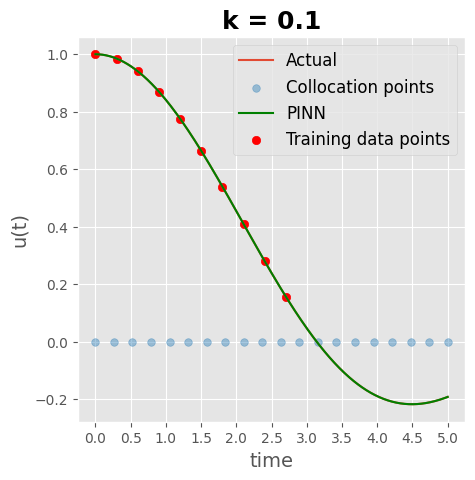

In [ ]:
title_font = {
    "fontsize" : 18,
    "fontweight": "bold"
}

plt.figure(figsize=(5, 5))
plt.style.use("ggplot")
plt.xticks(np.arange(0, 7.5, step=0.5))
plt.title("k = 0.1", title_font)
plt.plot(x, y, label="Actual")
plt.xlabel("time", fontsize=14)
plt.scatter(x_physics.detach().numpy(), -0*(x_physics.detach().numpy()), s=30, color="tab:blue", alpha=0.4, label='Collocation points')
plt.plot(x, y_pred, label="PINN", c="g")
plt.ylabel("u(t)", fontsize=14)
plt.scatter(x_data.reshape(-1,), y_data.reshape(-1,), c="r", label="Training data points")
plt.legend(fontsize="large")
plt.show()

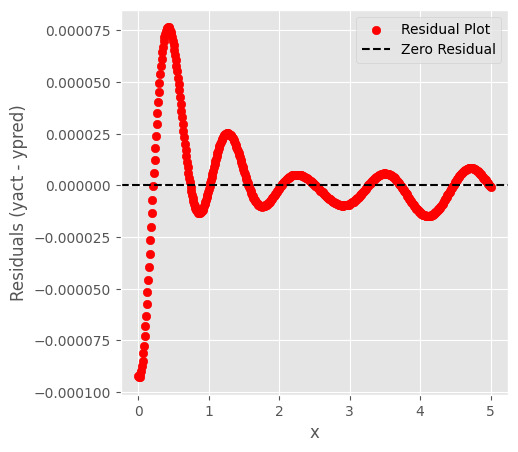

In [ ]:
residuals = y - y_pred
plt.figure(figsize=(5, 5))
plt.scatter(x, residuals, color='r', label='Residual Plot')
plt.axhline(y=0, color='k', linestyle='--', label='Zero Residual')
plt.xlabel('x')
plt.ylabel('Residuals (yact - ypred)')
plt.legend()
plt.show()

<b>Research Paper's Error: 3.16 x 10^-9</b>
<br>
<b>Our Final Error: 5.509427261148737e-10</b>


In [ ]:
x = np.linspace(0, 5, 500).reshape(-1, 1)  #Training Points
y = solution(x).reshape(-1, 1)

x_data = x[0:300:30] #Reducing the training points
y_data = y[0:300:30]

x_data = torch.tensor(x_data, dtype=torch.float32)
y_data = torch.tensor(y_data, dtype=torch.float32)

x_physics = torch.linspace(0, 5, 20, requires_grad=True, dtype=torch.float32).reshape(-1, 1) #20 Collocation Points

In [ ]:
def plot_result(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,yh, color="tab:red", linewidth=2, alpha=0.8, label="NN prediction")
    plt.plot(x,y, color="blue", linewidth=2, alpha=0.8,linestyle='--',label="Exact solution")
    plt.scatter(x_data, y_data, s=60, color="tab:red", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=30, color="tab:green", alpha=0.4,
                    label='Collocation points')
    l = plt.legend(loc=(0.63,0.42), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.025, 5.05)
    plt.ylim(-0.65, 1.25)
    plt.text(3.,1.05,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.ylabel('y',fontsize="xx-large")
    plt.xlabel('Radius (x)',fontsize="xx-large")
    plt.axis("on")

In [ ]:
EPOCHS = 20000
LR = 3e-3

model = NeuralNetwork(hidden_layers=5, hidden_nodes=24)
optim = torch.optim.Adam(model.parameters(),lr=LR)
scheduler = ReduceLROnPlateau(optim, mode='min', factor=0.1, patience=1000, verbose=True)
data_loss = nn.MSELoss()

loss_history = []
loss2_history = []
loss1_history = []
mse_history =[]

for epoch in range(EPOCHS):
    optim.zero_grad()

    # Compute the "data loss"
    y_pred = model(x_data)
    loss_y = data_loss(y_pred, y_data)

    # Compute the Derivates of the model WRT inputs
    u   = model(x_physics)
    du  = ag.grad(u, x_physics, torch.ones_like(u), create_graph=True)[0]
    ddu = ag.grad(du,  x_physics, torch.ones_like(du),  create_graph=True)[0]

    # BC condition on x=0
    loss_y=loss_y + 0.01*(du[0]**2)

    # Compute the physics loss
    physics = x_physics*ddu + 2*du + u*x_physics
    loss_f = torch.mean(physics**2)

    # backpropagate joint loss
    loss = loss_y + 0.163*loss_f # add two loss terms together with more weight to physics loss
    loss.backward()
    optim.step()
    scheduler.step(loss)

    if (epoch) % 100 == 0:
        loss_history.append(loss.detach())
        loss2_history.append(loss_f.detach())
        loss1_history.append(loss_y.detach())
        x = torch.tensor(x, dtype=torch.float32)
        y_prime = model(x).detach()

        mse= torch.mean((y_prime-y)**2)
        mse_history.append(mse.detach())

    if epoch % 1000 == 0:
        print(f"Epochs = {epoch} of {EPOCHS}, Loss = {float(loss):.4e}")

<ipython-input-351-0d02d6c92385>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Epochs = 0 of 20000, Loss = 6.4188e-01
Epochs = 1000 of 20000, Loss = 7.6394e-05
Epochs = 2000 of 20000, Loss = 1.7105e-05
Epochs = 3000 of 20000, Loss = 3.3123e-05
Epochs = 4000 of 20000, Loss = 1.6958e-04
Epochs = 5000 of 20000, Loss = 1.9121e-05
Epochs = 6000 of 20000, Loss = 3.3545e-05
Epochs = 7000 of 20000, Loss = 1.0169e-04
Epochs = 8000 of 20000, Loss = 4.7456e-06
Epochs = 9000 of 20000, Loss = 5.1045e-07
Epochs = 10000 of 20000, Loss = 1.6534e-06
Epochs = 11000 of 20000, Loss = 1.5304e-06
Epochs = 12000 of 20000, Loss = 1.2273e-07
Epochs = 13000 of 20000, Loss = 2.2830e-06
Epochs = 14000 of 20000, Loss = 1.0876e-05
Epoch 14669: reducing learning rate of group 0 to 3.0000e-04.
Epochs = 15000 of 20000, Loss = 8.0913e-08
Epochs = 16000 of 20000, Loss = 7.1439e-08
Epochs = 17000 of 20000, Loss = 5.9456e-08
Epochs = 18000 of 20000, Loss = 4.4808e-08
Epochs = 19000 of 20000, Loss = 2.9319e-08


In [ ]:
model.eval()
y_pred = model(torch.tensor(x, dtype = torch.float32).reshape(-1,1))
y_pred = y_pred.detach().cpu().numpy().reshape(-1,1)

<ipython-input-352-cbac79851b5d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model(torch.tensor(x, dtype = torch.float32).reshape(-1,1))


In [ ]:
squared_error = (y - y_pred)**2
loss_pred = np.mean(squared_error)
print(loss_pred.item())

3.9643603300862295e-10


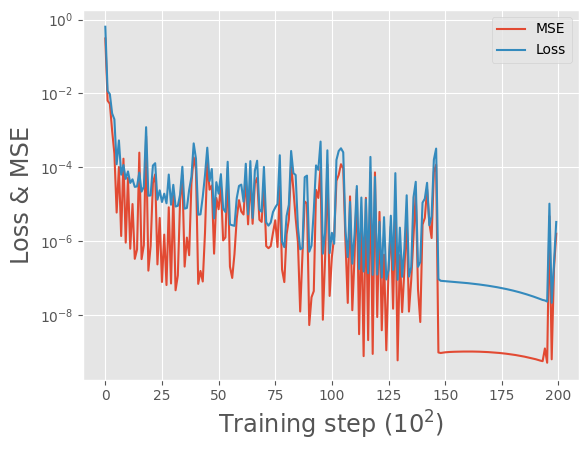

In [ ]:
plt.plot(mse_history,label='MSE')
plt.plot(loss_history,label='Loss')
plt.xlabel('Training step ($10^2$)',fontsize="xx-large")
plt.ylabel('Loss & MSE',fontsize="xx-large")
plt.yscale('log')
plt.legend()

In [ ]:
x = np.linspace(0, 5, 500).reshape(-1, 1)  #Training Points
y = solution(x).reshape(-1, 1)
yderiv = derivative(x).reshape(-1,1)
xn = torch.linspace(0,5,500).reshape(-1,1)
xn2 = torch.linspace(0,5,500).reshape(-1,1).requires_grad_(True)

yff = model(xn2)
der = torch.autograd.grad(yff, xn2, torch.ones_like(yff), create_graph=True)[0]
deriv= der.detach().numpy()

ypre = model(xn).detach().numpy()

<ipython-input-363-94b042216f27>:2: RuntimeWarning: divide by zero encountered in divide
  yd = np.cos(x)/x - np.sin(x)/x**2
<ipython-input-363-94b042216f27>:2: RuntimeWarning: invalid value encountered in divide
  yd = np.cos(x)/x - np.sin(x)/x**2


Text(0.5, 1.0, 'error on sol')

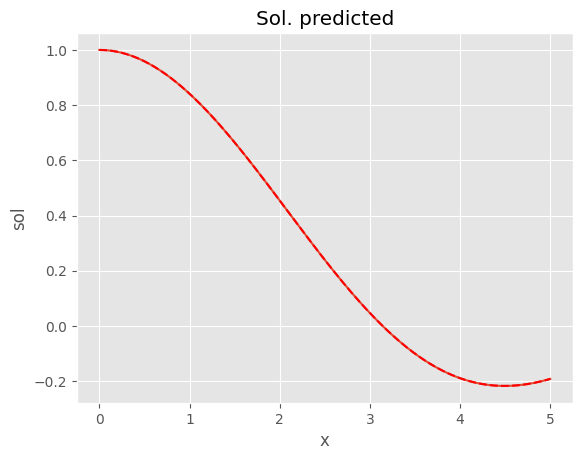

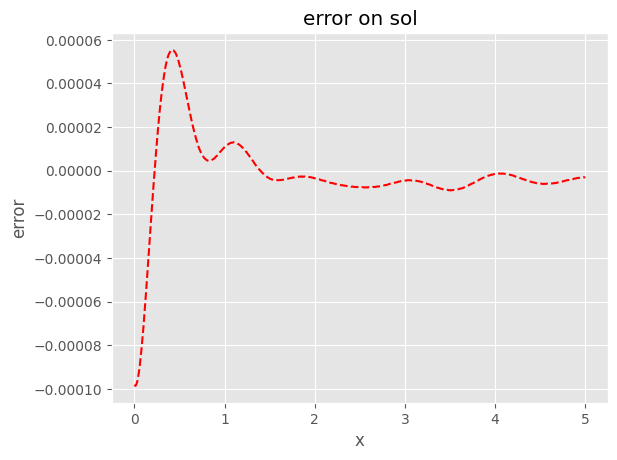

In [ ]:
fig1 = plt.figure(1)
plt.plot(xn, ypre)
plt.plot(xn, y,'r--')
plt.xlabel("x")
plt.ylabel("sol")
plt.title("Sol. predicted")

fig2 = plt.figure(2)
plt.plot(xn, y-ypre,'r--')
plt.xlabel("x")
plt.ylabel("error")
plt.title("error on sol")

Text(0.5, 1.0, 'error on der')

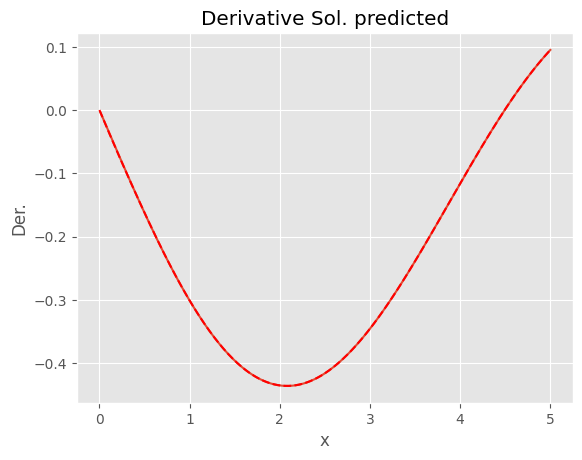

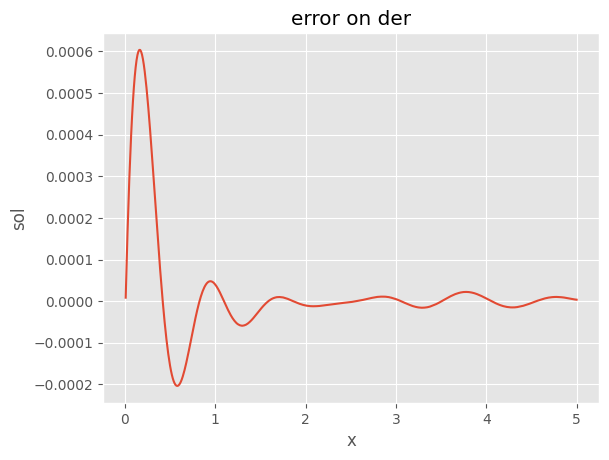

In [ ]:
fig3 = plt.figure(3)
plt.plot(xn, yderiv)
plt.plot(xn, deriv,'r--')
plt.xlabel("x")
plt.ylabel("Der.")
plt.title("Derivative Sol. predicted")

fig4 = plt.figure(4)
plt.plot(xn, yderiv-deriv )
plt.xlabel("x")
plt.ylabel("sol")
plt.title("error on der")

We can compare the following plots to that of the paper and easily conclude that our model works significantly better than that given in paper.



---

